# Modeling Notebook for Final Project

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import os
import warnings
from tqdm import tqdm
import torch
import zipfile


/Users/shikh/opt/anaconda3/lib/python3.9/site-packages/pandas/core/computation/expressions.py:21: UserWarning: Pandas requires version '2.8.0' or newer of 'numexpr' (version '2.7.3' currently installed).
  from pandas.core.computation.check import NUMEXPR_INSTALLED
/Users/shikh/opt/anaconda3/lib/python3.9/site-packages/pandas/core/arrays/masked.py:62: UserWarning: Pandas requires version '1.3.4' or newer of 'bottleneck' (version '1.3.2' currently installed).
  from pandas.core import (


## Getting the data

In [ ]:
# unzip the Data.zip file
# zipfile.ZipFile('Data.zip').extractall()

In [2]:
df_demo = pd.read_csv("Data/machine_learning_TJ_v7_demographics.csv")
df_vitals_imputed = pd.read_csv("Data/machine_learning_TJ_v7_vitals_mean_imputed_scaled.csv")
df_vitals_raw = pd.read_csv("Data/machine_learning_TJ_v7_vitals.csv")
df_oxy = pd.read_csv("Data/Oxygen_Data.csv")
df_labs_imputed = pd.read_csv("Data/machine_learning_TJ_v7_labs_mean_imputed_scaled.csv")
df_labs_raw = pd.read_csv("Data/machine_learning_TJ_v7_labs.csv")

In [3]:
# Columns of all the dataframes
df_names = ["df_demo", "df_vitals_imputed", "df_vitals_raw", "df_oxy", "df_labs_imputed", "df_labs_raw"]
dfs = [df_demo, df_vitals_imputed, df_vitals_raw, df_oxy, df_labs_imputed, df_labs_raw]
for df, name in zip(dfs, df_names):
    print("Dataframe shape and columns for ", name)
    print(df.shape)
    print(df.columns)

Dataframe shape and columns for  df_demo
(21312, 22)
Index(['patient_id_deident', 'class', 'disch_date_indexed',
       'death_date_indexed', 'age', 'admit_quarter', 'admit_year',
       'race_BLACK', 'race_OTHER', 'race_UNKNOWN', 'race_WHITE', 'gender_F',
       'gender_M', 'gender_UNKNOWN', 'ethnicity_HISPANIC OR LATINO',
       'ethnicity_NOT HISPANIC OR LATINO', 'ethnicity_UNKNOWN',
       'financial_class_COMMERCIAL', 'financial_class_MEDICAID',
       'financial_class_MEDICARE', 'financial_class_SELF PAY',
       'financial_class_UNKNOWN'],
      dtype='object')
Dataframe shape and columns for  df_vitals_imputed
(17717, 271)
Index(['patient_id_deident', 'VITALS_Mean Arterial Pressure_703306_0',
       'VITALS_Mean Arterial Pressure_703306_1',
       'VITALS_Mean Arterial Pressure_703306_2',
       'VITALS_Mean Arterial Pressure_703306_3',
       'VITALS_Mean Arterial Pressure_703306_4',
       'VITALS_Mean Arterial Pressure_703306_5',
       'VITALS_Mean Arterial Pressure_703306_

## Data cleaning and dataset creation

With this cell, we merge the datasets into a singular dataset of patient data. We also take the most prudent non-time-series features and concatenate them with the time series features while normalizing them using min-max normalization. We also fill NaN values with -1.

In [4]:
# choose the raw or imputed data
df_vitals = df_vitals_raw
df_labs = df_labs_raw
# df_vitals = df_vitals_imputed
# df_labs = df_labs_imputed

In [5]:
import re
# make notebook output length unlimited
pd.options.display.max_rows = 100000
df_demo1 = df_demo[['patient_id_deident','race_BLACK',
'race_UNKNOWN',
'race_OTHER',
'race_WHITE',
'ethnicity_HISPANIC OR LATINO',
'ethnicity_NOT HISPANIC OR LATINO',
'ethnicity_UNKNOWN',
'gender_F',
'gender_M',
'age',
'admit_quarter',
'admit_year',
'class', 'disch_date_indexed', 'death_date_indexed']]
# only keep the patients that are common to all dataframes
df_combined = pd.merge(df_demo1, df_vitals, on='patient_id_deident', how='inner')
df_combined = pd.merge(df_combined, df_oxy, on='patient_id_deident', how='inner')
df_combined = pd.merge(df_combined, df_labs, on='patient_id_deident', how='inner')
print("Combined dataframe shape and columns")
print(df_combined.shape)

df_combined = df_combined.fillna(-1)
# transform all data points less than 1e-5 to 0
# print dtype of all columns
non_ts_columns = set()
time_series_columns = set()
for column in df_combined.columns:
    # if the column name ends in "_%d" or "_DAY%d" where %d is an integer, then it is a time series column
    fields = column.split('_')
    cols_to_ignore = ['VITALS_Glasgow Coma Score_703565', 'VITALS_Height (in)_8428412', 'patient_id_deident']
    if len(fields) > 1 and (re.match(r'\d+', fields[-1]) or re.match(r'DAY\d+', fields[-1])):
        # make the column name without the last field
        column_name = '_'.join(fields[:-1])
        if column_name not in cols_to_ignore:
            time_series_columns.add(column_name)
            # if raw column ends in _DAY%d, then rename it to _%d
            if re.match(r'DAY\d+', fields[-1]):
                # get number after DAY
                df_combined.rename(columns={column: column_name + '_' + fields[-1][3:]}, inplace=True)
                column = column_name + '_' + fields[-1][3:]
        else:
            df_combined.drop(columns=[column], inplace=True)
            continue
    else:
        if column in cols_to_ignore:
            df_combined.drop(columns=[column], inplace=True)
            continue
        non_ts_columns.add(column)
    if df_combined[column].dtype == 'float64':
        df_combined[column] = df_combined[column].astype(np.float32)
        df_combined[column] = df_combined[column].apply(lambda x: 0 if x >= -1e-5 and x <= 1e-5 else x)

# Drop rows where disch_date_indexed is -1
df_combined = df_combined[df_combined['disch_date_indexed'] != -1]
# make any rows where death date is not -1 have a discharge date of a large value
df_combined.loc[df_combined['death_date_indexed'] != -1, 'disch_date_indexed'] = 1e2
# drop the death date indexed column
df_combined.drop(columns=['death_date_indexed'], inplace=True)
non_ts_columns.remove('death_date_indexed')
# Drop the patient id column and reindex
df_combined = df_combined.reset_index(drop=True)
# for age column change ">89" to "89"
df_combined['age'] = df_combined['age'].apply(lambda x: 89 if x == '>89' else x)
# cast column to float
df_combined['age'] = df_combined['age'].astype(np.float32)

# except for the time series columns, normalize all the columns
for column in df_combined.columns:
    if column in time_series_columns:
        continue
    if column in non_ts_columns:
        continue
    if column == 'disch_date_indexed':
        continue
    if column == 'patient_id_deident':
        continue
    if column == 'class':
        continue
    # 0-1 normalize the column
    df_combined[column] = (df_combined[column] - df_combined[column].min()) / (df_combined[column].max() - df_combined[column].min())



print("Combined dataframe shape and columns post clean")
print(df_combined.shape)
print("Categorical columns")
print(non_ts_columns)
print(len(non_ts_columns))
print("Time series columns")
print(time_series_columns)
print(len(time_series_columns))






Combined dataframe shape and columns
(13935, 1696)
Combined dataframe shape and columns post clean
(13927, 1634)
Categorical columns
{'race_UNKNOWN', 'gender_F', 'ethnicity_NOT HISPANIC OR LATINO', 'gender_M', 'admit_quarter', 'ethnicity_HISPANIC OR LATINO', 'class', 'disch_date_indexed', 'admit_year', 'race_WHITE', 'race_OTHER', 'age', 'race_BLACK', 'ethnicity_UNKNOWN'}
14
Time series columns
{'OXYGEN_venturi_mask', 'LABS_.Auto Diff_Eos Auto_%', 'LABS_CBC with Diff_Platelet_Thou/cu mm', 'LABS_.Auto Diff_Abs Immature Grans_Thou/cu mm', 'OXYGEN_non_rebreather', 'VITALS_Dosing Weight (kg)_3160959', 'VITALS_Respiratory Rate_703540', 'LABS_.Auto Diff_Abs Eos_Thou/cu mm', 'LABS_.Auto Diff_Abs Neutro_Thou/cu mm', "LABS_CBC with Diff_Automated Nucleated RBC's_/100 WBC", 'LABS_Comprehensive Metabolic Panel_Total Protein_g/dL', 'LABS_CBC with Diff_MCHC_g/dL', 'OXYGEN_nasal_cannula', 'LABS_Comprehensive Metabolic Panel_Chloride_mmol/L', 'LABS_CBC with Diff_Hct_%', 'OXYGEN_room_air', 'OXYGEN_vent

Here we save or load the dataset.

In [6]:
# Save the cleaned dataframe
df_combined.to_csv("Data/patients_cleaned.csv", index=False)


In [ ]:
# Load the cleaned dataframe
df_combined = pd.read_csv("Data/patients_cleaned.csv")

Now, we treat all columns as time series columns, repeating the non-time-series columns 30 times. We will end up with a torch dataset of shape (*num patients*, *num features*, *30 days*)

In [ ]:
import torch
from tqdm import tqdm
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
# For each patient, create a 2d array of time series data with categorical data repeated
dataset = torch.zeros((len(df_combined), len(non_ts_columns) + len(time_series_columns) - 1, 30), device=device)
label_column = 'disch_date_indexed'
label_dataset = torch.zeros((len(df_combined)), dtype=torch.float32, device=device)

train_categorical_columns = non_ts_columns - set(['disch_date_indexed'])

# populate the dataset
for i in tqdm(range(len(df_combined))):
    for j, column in enumerate(train_categorical_columns):
            # convert numpy value to torch value
            dataset[i, j, :] = float(df_combined.loc[i, column])
    for j, column in enumerate(time_series_columns):
        for k in range(30):
            dataset[i, j + len(train_categorical_columns), k] = df_combined.loc[i, column + '_' + str(k)]
    label_dataset[i] = df_combined.loc[i, label_column]



In [ ]:
# save the torch tensors to a file
torch.save(dataset, "Data/dataset.pt")
torch.save(label_dataset, "Data/label_dataset.pt")

In [9]:
# load the torch tensors from a file
dataset = torch.load("Data/dataset.pt")
label_dataset = torch.load("Data/label_dataset.pt")

(0.0, 100.0)

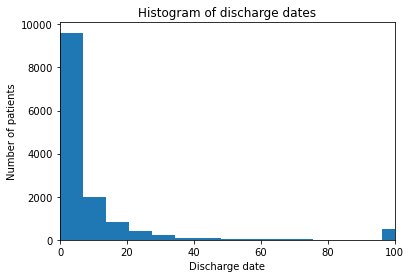

In [10]:
# make histogram of discharge dates
plt.hist(label_dataset.cpu().numpy(), bins=30)
plt.xlabel("Discharge date")
plt.ylabel("Number of patients")
plt.title("Histogram of discharge dates")
plt.xlim(0, 100)

Here we can see the distribution of discharge dates is heavily skewed to the right. Thus, we will try transforming the data.

Text(0.5, 1.0, 'Histogram of transformed discharge dates')

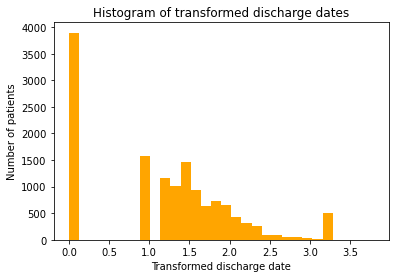

In [11]:
# data is heavily skewed towards the left, so we will take the log log of the discharge dates
label_dataset_root = np.sqrt(np.sqrt(label_dataset))
# label_dataset_log = np.log((label_dataset + 1))
plt.hist(label_dataset_root.cpu().numpy(), bins=30, color='orange')
# plt.hist(label_dataset_log.cpu().numpy(), bins=30, color='red')
plt.xlabel("Transformed discharge date")
plt.ylabel("Number of patients")
plt.title("Histogram of transformed discharge dates")


In [29]:
from scipy.stats import skew
print("Skew of discharge dates")
print(skew(label_dataset.cpu().numpy()))
print("Skew of transformed discharge dates")
print(skew(label_dataset_root.cpu().numpy()))

Skew of discharge dates
3.6132775666341086
Skew of transformed discharge dates
0.0835667095975077


We can see that the 4th root provides a much more balanced dataset.

In [12]:
label_dataset_transformed = label_dataset_root

def transform_back(x):
    return np.power(x, 4)

To compare models trained on data which includes only the first 1, 2, 3, 4, ..., 30 days worth of data, we will create subset datasets.

In [13]:
# build 30 datasets, each including the first i time steps
datasets = []
for i in range(1, 31):
    datasets.append(dataset[:, :, :i])

# save the datasets to a file
for i, dataset in enumerate(datasets):
    torch.save(dataset, "Data/dataset_" + str(i + 1) + ".pt")

## Modeling and Visualization

We will first start by attempting to train a Linear Regression model.

In [14]:
# Fit a simple linear regression model to the data
from sklearn.linear_model import LinearRegression
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error
from sklearn.preprocessing import StandardScaler

scaler = StandardScaler()



In [15]:
mses_linear_all = []
extrapolation_mse_linear_all = []
for i in tqdm(range(1, 31)):
    dataset = torch.load("Data/dataset_" + str(i) + ".pt")
    X_train, X_test, y_train, y_test = train_test_split(dataset.cpu().numpy(), label_dataset_transformed.cpu().numpy(), test_size=0.2, random_state=42)
    model = LinearRegression()
    model.fit(X_train.reshape(X_train.shape[0], -1), y_train)
    y_pred = model.predict(X_test.reshape(X_test.shape[0], -1))
    mse = mean_squared_error(y_test, y_pred)
    mses_linear_all.append(mse)
    # find mse for y values larger than i
    y_test_extrapolation = y_test[transform_back(y_test) > i]
    y_pred_extrapolation = y_pred[transform_back(y_test) > i]
    mse_extrapolation = mean_squared_error(y_test_extrapolation, y_pred_extrapolation)
    extrapolation_mse_linear_all.append(mse_extrapolation)



print("Average MSE for linear regression model for all features: ", np.mean(mses_linear_all))
print("Best MSE for linear regression model for all features: ", np.min(mses_linear_all), "for ", np.argmin(mses_linear_all) + 1, "days")
print("Worst MSE for linear regression model for all features: ", np.max(mses_linear_all), "for ", np.argmax(mses_linear_all) + 1, "days")
print("Average MSE for linear regression model for all features for extrapolation: ", np.mean(extrapolation_mse_linear_all))
print("Best MSE for linear regression model for all features for extrapolation: ", np.min(extrapolation_mse_linear_all), "for ", np.argmin(extrapolation_mse_linear_all) + 1, "days")
print("Worst MSE for linear regression model for all features for extrapolation: ", np.max(extrapolation_mse_linear_all), "for ", np.argmax(extrapolation_mse_linear_all) + 1, "days")




100%|██████████| 30/30 [00:43<00:00,  1.43s/it]

Average MSE for linear regression model for all features:  0.3545523
Best MSE for linear regression model for all features:  0.21307197 for  14 days
Worst MSE for linear regression model for all features:  2.4876814 for  30 days
Average MSE for linear regression model for all features for extrapolation:  2.1021302
Best MSE for linear regression model for all features for extrapolation:  0.32937044 for  1 days
Worst MSE for linear regression model for all features for extrapolation:  30.58408 for  30 days


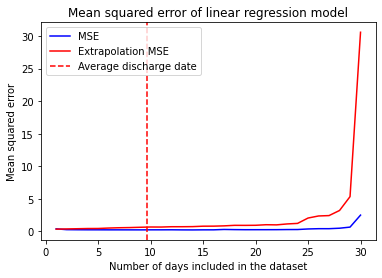

In [16]:
# graph the mean squared error
plt.plot(range(1, 31), mses_linear_all, label="MSE", color='b')
plt.plot(range(1, 31), extrapolation_mse_linear_all, label="Extrapolation MSE", color='r')
plt.xlabel("Number of days included in the dataset")
plt.ylabel("Mean squared error")
plt.title("Mean squared error of linear regression model")
# draw a line at the average discharge date on the x-axis
plt.axvline(x=np.mean(label_dataset.cpu().numpy()), color='r', linestyle='--', label="Average discharge date")
plt.legend()
plt.show()


Interestingly, here we see that the lowest MSE comes from only including 14 days worth of data.

Text(0.5, 1.0, 'Predicted discharge date vs actual discharge date')

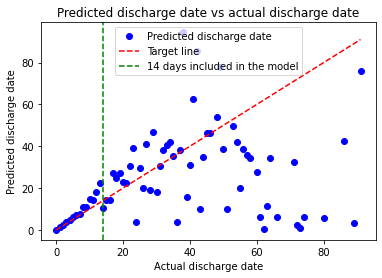

In [18]:
# sort the patients by discharge date
# get the predicted discharge date
dataset = torch.load("Data/dataset_" + '14' + ".pt")
X_train, X_test, y_train, y_test = train_test_split(dataset.cpu().numpy(), label_dataset_transformed.cpu().numpy(), test_size=0.2, random_state=42)
model = LinearRegression()
model.fit(X_train.reshape(X_train.shape[0], -1), y_train)
# sort X_test and y_test by discharge date
predicted = []
actual = []
y_test_transformed = transform_back(y_test)
# round the discharge date to the nearest integer
y_test_transformed = np.round(y_test_transformed)
for actual_discharge_date in range(0, 100):
    # transform the predicted discharge date to the original scale

    indices = np.where(y_test_transformed == actual_discharge_date)[0]
    # append the average predicted discharge date for the patients with the same actual discharge date
    if len(indices) > 0:
        predicted.append(np.mean(transform_back(model.predict(X_test[indices].reshape(len(indices), -1)))))
        actual.append(actual_discharge_date)


# plot the predicted discharge date vs the actual discharge date
plt.plot(actual, predicted, 'o', color='b', label="Predicted discharge date")
plt.plot(actual, actual, color='r', linestyle='--', label="Target line")
# vertical line for how many days the model was trained on
plt.axvline(x=14, color='g', linestyle='--', label='14 days included in the model')
plt.legend()
plt.xlabel("Actual discharge date")
plt.ylabel("Predicted discharge date")
plt.title("Predicted discharge date vs actual discharge date")


This graph is created by taking all true patient discharge dates from 0 - 100 (on the x axis), and then taking the model's average predicted discharge dates for all patients corresponding to each true discharge date. For example, if there are 5 patients discharged at day 20, then the value plotted will be the mean predicted discharge date for those patients by the model. Thus, the more linear, the better (as depicted by the red line). The green line shows how many days worth of data were included in the model (in this case, 14 days).

Text(0.5, 1.0, 'Predicted discharge date vs actual discharge date')

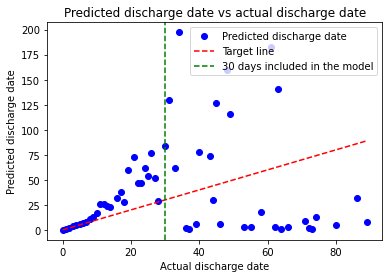

In [19]:
# make the same plot for 30 days
dataset = torch.load("Data/dataset_" + '30' + ".pt")
X_train, X_test, y_train, y_test = train_test_split(dataset.cpu().numpy(), label_dataset_transformed.cpu().numpy(), test_size=0.2, random_state=42)
model = LinearRegression()
model.fit(X_train.reshape(X_train.shape[0], -1), y_train)
# sort X_test and y_test by discharge date
predicted = []
actual = []
y_test_transformed = transform_back(y_test)
# round the discharge date to the nearest integer
y_test_transformed = np.round(y_test_transformed)
for actual_discharge_date in range(0, 100):
    # transform the predicted discharge date to the original scale

    indices = np.where(y_test_transformed == actual_discharge_date)[0]
    # append the average predicted discharge date for the patients with the same actual discharge date
    if len(indices) > 0:
        pred_mean = np.mean(transform_back(model.predict(X_test[indices].reshape(len(indices), -1))))
        if pred_mean > 200:
            continue

        predicted.append(np.mean(transform_back(model.predict(X_test[indices].reshape(len(indices), -1)))))
        actual.append(actual_discharge_date)

# plot the predicted discharge date vs the actual discharge date
plt.plot(actual, predicted, 'o', color='b', label="Predicted discharge date")
plt.plot(actual, actual, color='r', linestyle='--', label="Target line")
# vertical line for how many days the model was trained on
plt.axvline(x=30, color='g', linestyle='--', label='30 days included in the model')
plt.legend()
plt.xlabel("Actual discharge date")
plt.ylabel("Predicted discharge date")
plt.title("Predicted discharge date vs actual discharge date")


In [20]:
# Train a simple feed forward neural network
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import DataLoader, TensorDataset

class SimpleNN(nn.Module):
    def __init__(self, input_size, hidden_size, output_size):
        super(SimpleNN, self).__init__()
        self.fc1 = nn.Linear(input_size, hidden_size)
        self.relu = nn.ReLU()
        self.fc2 = nn.Linear(hidden_size, output_size)
    def forward(self, x):
        x = self.fc1(x)
        x = self.relu(x)
        x = self.fc2(x)
        return x


In [21]:
mse_nn_all = []
extrapolation_mse_nn_all = []
best_model = None
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
for i in tqdm(range(1, 31)):
    dataset = torch.load("Data/dataset_" + str(i) + ".pt")
    X_train, X_test, y_train, y_test = train_test_split(dataset.cpu().numpy(), label_dataset_transformed.cpu().numpy(), test_size=0.2, random_state=42)
    X_train = torch.tensor(X_train, dtype=torch.float32, device=device)
    y_train = torch.tensor(y_train, dtype=torch.float32, device=device)
    X_test = torch.tensor(X_test, dtype=torch.float32, device=device)
    y_test = torch.tensor(y_test, dtype=torch.float32, device=device)
    train_dataset = TensorDataset(X_train, y_train)
    test_dataset = TensorDataset(X_test, y_test)
    train_loader = DataLoader(train_dataset, batch_size=32, shuffle=True)
    test_loader = DataLoader(test_dataset, batch_size=32, shuffle=False)
    model = SimpleNN(X_train.shape[1] * X_train.shape[2], 128, 1).to(device)
    criterion = nn.MSELoss()
    optimizer = optim.Adam(model.parameters(), lr=0.001)
    num_epochs = 100
    for epoch in range(num_epochs):
        model.train()
        for X, y in train_loader:
            optimizer.zero_grad()
            y_pred = model(X.reshape(X.shape[0], -1))
            loss = criterion(y_pred, y.unsqueeze(1))
            loss.backward()
            optimizer.step()
        model.eval()
        with torch.no_grad():
            losses = []
            extrapolation_losses = []
            for X, y in test_loader:
                y_pred = model(X.reshape(X.shape[0], -1))
                loss = criterion(y_pred, y.unsqueeze(1))
                losses.append(loss.item())
                for i in range(len(y)):
                    if transform_back(y[i].item()) > i:
                        extrapolation_losses.append((y_pred[i].item() - y[i].item()) ** 2)
    # get final mse loss on the test set
    mse_nn_all.append(np.mean(losses))
    extrapolation_mse_nn_all.append(np.mean(extrapolation_losses))
    if mse_nn_all[-1] == np.min(mse_nn_all):
        best_model = model

print("Average MSE for neural network model for all features: ", np.mean(mse_nn_all))
print("Best MSE for neural network model for all features: ", np.min(mse_nn_all), "for ", np.argmin(mse_nn_all) + 1, "days")
print("Worst MSE for neural network model for all features: ", np.max(mse_nn_all), "for ", np.argmax(mse_nn_all) + 1, "days")
print("Average MSE for neural network model for all features for extrapolation: ", np.mean(extrapolation_mse_nn_all))
print("Best MSE for neural network model for all features for extrapolation: ", np.min(extrapolation_mse_nn_all), "for ", np.argmin(extrapolation_mse_nn_all) + 1, "days")
print("Worst MSE for neural network model for all features for extrapolation: ", np.max(extrapolation_mse_nn_all), "for ", np.argmax(extrapolation_mse_nn_all) + 1, "days")



100%|██████████| 30/30 [35:05<00:00, 70.20s/it]

Average MSE for neural network model for all features:  0.13685745717570666
Best MSE for neural network model for all features:  0.08304190603997665 for  27 days
Worst MSE for neural network model for all features:  0.35668742521242663 for  1 days
Average MSE for neural network model for all features for extrapolation:  0.3104139144198521
Best MSE for neural network model for all features for extrapolation:  0.14104706047946258 for  30 days
Worst MSE for neural network model for all features for extrapolation:  0.4792866151341419 for  2 days


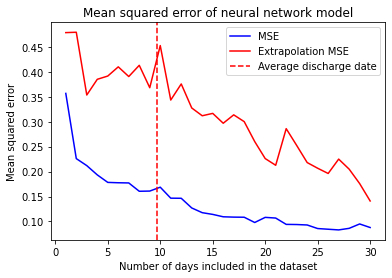

In [22]:
# plot mses
plt.plot(range(1,31), mse_nn_all, label="MSE", color='b')
plt.plot(range(1,31), extrapolation_mse_nn_all, label="Extrapolation MSE", color='r')
plt.xlabel("Number of days included in the dataset")
plt.ylabel("Mean squared error")
plt.title("Mean squared error of neural network model")
# draw a line at the average discharge date on the x-axis
plt.axvline(x=np.mean(label_dataset.cpu().numpy()), color='r', linestyle='--', label="Average discharge date")
plt.legend()
plt.show()


After training a feedforward network, we get a downward curve in MSE loss as we'd expect, with the best model at 27 days.

Text(0.5, 1.0, 'Predicted discharge date vs actual discharge date')

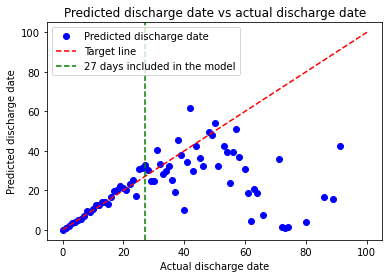

In [26]:
i = np.argmin(mse_nn_all)
dataset = torch.load("Data/dataset_" + str(i + 1) + ".pt")
X_train, X_test, y_train, y_test = train_test_split(dataset.cpu().numpy(), label_dataset_transformed.cpu().numpy(), test_size=0.2, random_state=42)
X_train = torch.tensor(X_train, dtype=torch.float32, device=device)
y_train = torch.tensor(y_train, dtype=torch.float32, device=device)
X_test = torch.tensor(X_test, dtype=torch.float32, device=device)
y_test = torch.tensor(y_test, dtype=torch.float32, device=device)

best_model.eval()
predicted = []
actual = []
y_test_transformed = transform_back(y_test)
# round the discharge date to the nearest integer
y_test_transformed = np.round(y_test_transformed)
for actual_discharge_date in range(0, 100):
    # transform the predicted discharge date to the original scale
    indices = np.where(y_test_transformed == actual_discharge_date)[0]
    # append the average predicted discharge date for the patients with the same actual discharge date
    if len(indices) > 0:
        predicted.append(np.mean(transform_back(best_model(X_test.reshape(X_test.shape[0], -1)[indices]).detach().cpu().numpy())))
        actual.append(actual_discharge_date)

plt.plot(actual, predicted, 'o', color='b', label="Predicted discharge date")
plt.plot([0, 100], [0, 100], color='r', linestyle='--', label="Target line")
# vertical line for how many days the model was trained on
plt.axvline(x=i+1, color='g', linestyle='--', label=str(i+1) + ' days included in the model')
plt.legend()
plt.xlabel("Actual discharge date")
plt.ylabel("Predicted discharge date")
plt.title("Predicted discharge date vs actual discharge date")






Text(0.5, 1.0, 'Predicted discharge date vs actual discharge date')

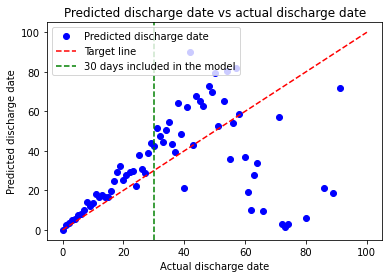

In [27]:
# make the same plot for 30 days
i = np.argmin(mse_nn_all)
dataset = torch.load("Data/dataset_" + '30' + ".pt")
X_train, X_test, y_train, y_test = train_test_split(dataset.cpu().numpy(), label_dataset_transformed.cpu().numpy(), test_size=0.2, random_state=42)
X_train = torch.tensor(X_train, dtype=torch.float32, device=device)
y_train = torch.tensor(y_train, dtype=torch.float32, device=device)
X_test = torch.tensor(X_test, dtype=torch.float32, device=device)
y_test = torch.tensor(y_test, dtype=torch.float32, device=device)

model.eval()
predicted = []
actual = []
y_test_transformed = transform_back(y_test)
# round the discharge date to the nearest integer
y_test_transformed = np.round(y_test_transformed)
for actual_discharge_date in range(0, 100):
    # transform the predicted discharge date to the original scale
    indices = np.where(y_test_transformed == actual_discharge_date)[0]
    # append the average predicted discharge date for the patients with the same actual discharge date
    if len(indices) > 0:
        predicted.append(np.mean(transform_back(model(X_test.reshape(X_test.shape[0], -1)[indices]).detach().cpu().numpy())))
        actual.append(actual_discharge_date)

plt.plot(actual, predicted, 'o', color='b', label="Predicted discharge date")
plt.plot([0, 100], [0, 100], color='r', linestyle='--', label="Target line")
# vertical line for how many days the model was trained on
plt.axvline(x=30, color='g', linestyle='--', label='30 days included in the model')
plt.legend()
plt.xlabel("Actual discharge date")
plt.ylabel("Predicted discharge date")
plt.title("Predicted discharge date vs actual discharge date")






In [28]:
print(mse_nn_all[-1])

0.08784258558245545


Here, the predicted discharge dates follow the target line pretty closely, indicating that this is a good model.

In [13]:
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import DataLoader, Dataset

class PatientDataset(Dataset):
    def __init__(self, features, labels):
        # features should be of shape (batch_size, 30, 67)
        # labels should be of shape (batch_size, )
        self.features = features
        self.labels = labels

    def __len__(self):
        return len(self.labels)

    def __getitem__(self, idx):
        return self.features[idx], self.labels[idx]

class PatientLSTM(nn.Module):
    def __init__(self, input_dim, hidden_dim, num_layers, dropout):
        super(PatientLSTM, self).__init__()
        self.lstm = nn.LSTM(
            input_size=input_dim,
            hidden_size=hidden_dim,
            num_layers=num_layers,
            batch_first=True,
            dropout=dropout
        )
        self.regressor = nn.Linear(hidden_dim, 1)

    def forward(self, x):
        x = x.permute(0, 2, 1) # change shape to batch_size, num_features, seq_len

        # x should be of shape (batch_size, sequence_length, num_features) -> (batch_size, 30, 67)
        lstm_out, _ = self.lstm(x)
        last_time_step_out = lstm_out[:, -1, :]
        output = self.regressor(last_time_step_out)
        return output.squeeze(1)

In [22]:
# Train the LSTM model
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
# mse_lstm = []
for i in tqdm(range(7, 31)):
  dataset = torch.load("Data/dataset_" + str(i) + ".pt")
  X_train, X_test, y_train, y_test = train_test_split(dataset.cpu().numpy(), label_dataset_transformed.cpu().numpy(), test_size=0.2, random_state=42)
  X_train = torch.tensor(X_train, dtype=torch.float32, device=device)
  y_train = torch.tensor(y_train, dtype=torch.float32, device=device)
  X_test = torch.tensor(X_test, dtype=torch.float32, device=device)
  y_test = torch.tensor(y_test, dtype=torch.float32, device=device)
  train_dataset = TensorDataset(X_train, y_train)
  test_dataset = TensorDataset(X_test, y_test)
  train_loader = DataLoader(train_dataset, batch_size=32, shuffle=True)
  test_loader = DataLoader(test_dataset, batch_size=32, shuffle=False)
  model = PatientLSTM(X_train.shape[1], 128, 2, 0.2).to(device)
  criterion = nn.MSELoss()
  optimizer = optim.Adam(model.parameters(), lr=1e-5)
  num_epochs = 100
  mse = []
  train_mse = []
  for epoch in range(num_epochs):
      num_batches = len(train_loader)
      model.train()
      total_loss = 0
      for X, y in train_loader:
          optimizer.zero_grad()
          y_pred = model(X)
          loss = criterion(y_pred, y.unsqueeze(1))
          loss.backward()
          optimizer.step()
          total_loss += loss.item()
      train_mse.append(total_loss / num_batches)
      model.eval()
      with torch.no_grad():
          losses = []
          for X, y in test_loader:
              y_pred = model(X)
              loss = criterion(y_pred, y)
              losses.append(loss.item())
          mse.append(np.mean(losses))
  mse_lstm.append(mse[-1])
print("Average MSE for neural network model for all features: ", np.mean(mse_lstm))
print("Best MSE for neural network model for all features: ", np.min(mse_lstm), "for ", np.argmin(mse_lstm) + 1, "days")
print("Worst MSE for neural network model for all features: ", np.max(mse_lstm), "for ", np.argmax(mse_lstm) + 1, "days")





100%|██████████| 24/24 [40:03<00:00, 100.13s/it]

Average MSE for neural network model for all features:  0.7220600307439312
Best MSE for neural network model for all features:  0.7170468992130323 for  11 days
Worst MSE for neural network model for all features:  0.7272953883829442 for  27 days


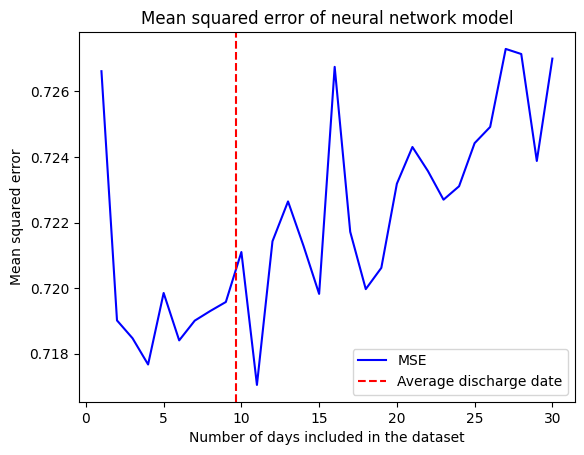

In [23]:
# plot mses
plt.plot(range(1, 31), mse_lstm, label="MSE", color='b')
plt.xlabel("Number of days included in the dataset")
plt.ylabel("Mean squared error")
plt.title("Mean squared error of neural network model")
# draw a line at the average discharge date on the x-axis
plt.axvline(x=np.mean(label_dataset.cpu().numpy()), color='r', linestyle='--', label="Average discharge date")
plt.legend()
plt.show()

/usr/local/lib/python3.10/dist-packages/torch/nn/modules/loss.py:535: UserWarning: Using a target size (torch.Size([32, 1])) that is different to the input size (torch.Size([32])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)
/usr/local/lib/python3.10/dist-packages/torch/nn/modules/loss.py:535: UserWarning: Using a target size (torch.Size([5, 1])) that is different to the input size (torch.Size([5])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)


Text(0.5, 1.0, 'Predicted discharge date vs actual discharge date')

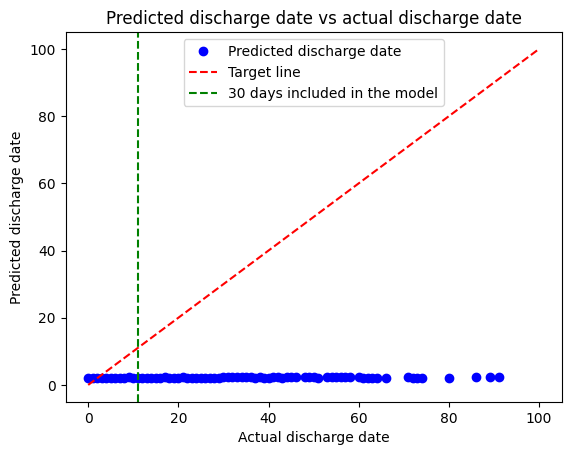

In [24]:
dataset = torch.load("Data/dataset_" + '11' + ".pt")
X_train, X_test, y_train, y_test = train_test_split(dataset.cpu().numpy(), label_dataset_transformed.cpu().numpy(), test_size=0.2, random_state=42)
X_train = torch.tensor(X_train, dtype=torch.float32, device=device)
y_train = torch.tensor(y_train, dtype=torch.float32, device=device)
X_test = torch.tensor(X_test, dtype=torch.float32, device=device)
y_test = torch.tensor(y_test, dtype=torch.float32, device=device)
train_dataset = TensorDataset(X_train, y_train)
test_dataset = TensorDataset(X_test, y_test)
train_loader = DataLoader(train_dataset, batch_size=32, shuffle=True)
test_loader = DataLoader(test_dataset, batch_size=32, shuffle=False)
model = PatientLSTM(X_train.shape[1], 128, 2, 0.2).to(device)
criterion = nn.MSELoss()
optimizer = optim.Adam(model.parameters(), lr=1e-5)
num_epochs = 100
mse = []
train_mse = []
for epoch in range(num_epochs):
    num_batches = len(train_loader)
    model.train()
    total_loss = 0
    for X, y in train_loader:
        optimizer.zero_grad()
        y_pred = model(X)
        loss = criterion(y_pred, y.unsqueeze(1))
        loss.backward()
        optimizer.step()
        total_loss += loss.item()
    train_mse.append(total_loss / num_batches)
    model.eval()
predicted = []
actual = []
y_test_transformed = transform_back(y_test.detach().cpu().numpy())
# round the discharge date to the nearest integer
y_test_transformed = np.round(y_test_transformed)
for actual_discharge_date in range(0, 100):
    # transform the predicted discharge date to the original scale
    indices = np.where(y_test_transformed == actual_discharge_date)[0]
    # append the average predicted discharge date for the patients with the same actual discharge date
    if len(indices) > 0:

        predicted.append(np.mean(transform_back(model(X_test[indices]).detach().cpu().numpy())))
        actual.append(actual_discharge_date)

plt.plot(actual, predicted, 'o', color='b', label="Predicted discharge date")
plt.plot([0, 100], [0, 100], color='r', linestyle='--', label="Target line")
# vertical line for how many days the model was trained on
plt.axvline(x=11, color='g', linestyle='--', label='30 days included in the model')
plt.legend()
plt.xlabel("Actual discharge date")
plt.ylabel("Predicted discharge date")
plt.title("Predicted discharge date vs actual discharge date")



In [ ]:
# prompt: train the lstm model

# Train the LSTM model

i = 5
dataset = torch.load("Data/dataset_" + str(i) + ".pt")
X_train, X_test, y_train, y_test = train_test_split(dataset.cpu().numpy(), label_dataset_transformed.cpu().numpy(), test_size=0.2, random_state=42)
X_train = torch.tensor(X_train, dtype=torch.float32, device=device)
y_train = torch.tensor(y_train, dtype=torch.float32, device=device)
X_test = torch.tensor(X_test, dtype=torch.float32, device=device)
y_test = torch.tensor(y_test, dtype=torch.float32, device=device)
train_dataset = TensorDataset(X_train, y_train)
test_dataset = TensorDataset(X_test, y_test)
train_loader = DataLoader(train_dataset, batch_size=32, shuffle=True)
test_loader = DataLoader(test_dataset, batch_size=32, shuffle=False)
model = PatientLSTM(X_train.shape[1], 128, 2, 0.1).to(device)
criterion = nn.MSELoss()
optimizer = optim.Adam(model.parameters(), lr=1e-5)
num_epochs = 100
mse = []
train_mse = []
for epoch in tqdm(range(num_epochs)):
    num_batches = len(train_loader)
    model.train()
    total_loss = 0
    for X, y in train_loader:
        optimizer.zero_grad()
        y_pred = model(X)
        loss = criterion(y_pred, y.unsqueeze(1))
        loss.backward()
        optimizer.step()
        total_loss += loss.item()
    train_mse.append(total_loss / num_batches)
    model.eval()
    with torch.no_grad():
        losses = []
        for X, y in test_loader:
            y_pred = model(X)
            loss = criterion(y_pred, y)
            losses.append(loss.item())
        mse.append(np.mean(losses))
    if epoch % 10 == 0:
      print("Train MSE:", train_mse[-1])
      print("MSE: ", mse[-1])



  1%|          | 1/100 [00:00<01:31,  1.08it/s]

Train MSE: 1.3052300558049221
MSE:  0.8107091313736006


 11%|█         | 11/100 [00:10<01:24,  1.05it/s]

Train MSE: 0.7471882972471352
MSE:  0.729550092142414


 21%|██        | 21/100 [00:20<01:17,  1.02it/s]

Train MSE: 0.749022933849291
MSE:  0.7232927547090433


 31%|███       | 31/100 [00:30<01:11,  1.03s/it]

Train MSE: 0.7483151107599537
MSE:  0.7199991452931003


 41%|████      | 41/100 [00:39<00:54,  1.09it/s]

Train MSE: 0.7469250331806249
MSE:  0.71970714205368


 51%|█████     | 51/100 [00:48<00:45,  1.08it/s]

Train MSE: 0.7472779932712074
MSE:  0.7182809098369696


 61%|██████    | 61/100 [00:58<00:37,  1.05it/s]

Train MSE: 0.7484777184219278
MSE:  0.7173926969143477


 71%|███████   | 71/100 [01:08<00:28,  1.02it/s]

Train MSE: 0.7484334621866658
MSE:  0.7179359197616577


 81%|████████  | 81/100 [01:17<00:19,  1.02s/it]

Train MSE: 0.7474261299416124
MSE:  0.7203951676122167


 91%|█████████ | 91/100 [01:27<00:08,  1.05it/s]

Train MSE: 0.7473085621708102
MSE:  0.7195784732360732


100%|██████████| 100/100 [01:36<00:00,  1.04it/s]


Text(0.5, 1.0, 'Predicted discharge date vs actual discharge date')

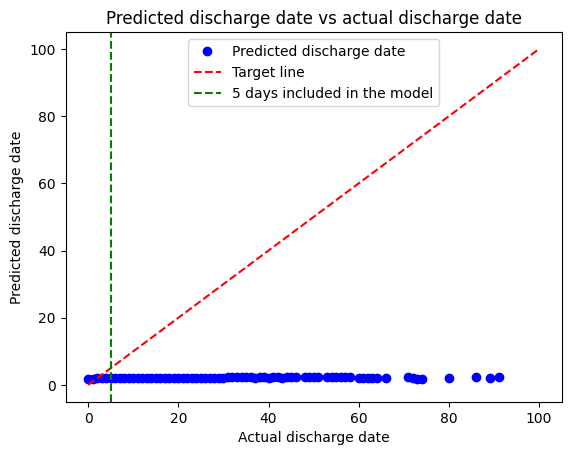

In [ ]:
model.eval()
predicted = []
actual = []
y_test_transformed = transform_back(y_test.detach().cpu().numpy())
# round the discharge date to the nearest integer
y_test_transformed = np.round(y_test_transformed)
for actual_discharge_date in range(0, 100):
    # transform the predicted discharge date to the original scale
    indices = np.where(y_test_transformed == actual_discharge_date)[0]
    # append the average predicted discharge date for the patients with the same actual discharge date
    if len(indices) > 0:

        predicted.append(np.mean(transform_back(model(X_test[indices]).detach().cpu().numpy())))
        actual.append(actual_discharge_date)

plt.plot(actual, predicted, 'o', color='b', label="Predicted discharge date")
plt.plot([0, 100], [0, 100], color='r', linestyle='--', label="Target line")
# vertical line for how many days the model was trained on
plt.axvline(x=5, color='g', linestyle='--', label='5 days included in the model')
plt.legend()
plt.xlabel("Actual discharge date")
plt.ylabel("Predicted discharge date")
plt.title("Predicted discharge date vs actual discharge date")

